In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


/var/folders/0c/h9fhkgpn5bsffbb_lm11_n6m0000gn/T/ipykernel_49518/3164123317.py:32: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented.

In [2]:
import os
import pandas as pd

def read_csv_files(df_preprocessed,folder_path):
    if not os.path.exists(folder_path):
        print(f"The folder path '{folder_path}' does not exist.")
        return None

    files = os.listdir(folder_path)

    csv_files = [file for file in files if file.endswith('.csv')]

    dataframes = {}

    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        dataframe = pd.read_csv(file_path)
        filename = os.path.splitext(csv_file)[0]
        dataframe['game'] = int(filename[4])
        dataframe['subject'] = int(filename[1:3])
        df_preprocessed = pd.concat([df_preprocessed, dataframe], axis=0)


    return df_preprocessed

In [3]:
folder_path="GAMEEMO"

In [4]:
files = os.listdir(folder_path)

In [5]:
def select_filenames_starting_with_S(file_names):
    selected_files = [file_name for file_name in file_names if file_name.startswith("(S")]
    return selected_files


In [6]:
files = select_filenames_starting_with_S(files)

In [7]:
folder_path

'GAMEEMO'

In [8]:
file_path_pre = []
file_path_raw = []

In [9]:
for file in files:
    file = folder_path+'/'+str(file)+"/Preprocessed EEG Data/.csv format/"
    file_path_pre.append(file)

for file in files:
    file = folder_path+'/'+str(file)+"/Raw EEG Data/.csv format/"
    file_path_raw.append(file)

In [10]:
df_preprocessed = pd.DataFrame()
df_raw = pd.DataFrame()

In [11]:
for path in file_path_pre:
    df_preprocessed = read_csv_files(df_preprocessed,path)

for path in file_path_raw:
    df_raw = read_csv_files(df_raw,path)


In [12]:
df_preprocessed=df_preprocessed.drop(columns='Unnamed: 14')
df_raw=df_raw.drop(columns=["Unnamed: 14","eeg","Unnamed: 15"])

In [13]:
df_raw_data = df_raw.drop(columns=['subject','game'])
df_preprocessed_data = df_preprocessed.drop(columns=['subject','game'])

In [14]:
channels=['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7','P8', 'T7', 'T8']

In [15]:
ch_types=['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']

In [16]:
sampling_freq=128

In [17]:
filtered_df_pre = df_preprocessed[(df_preprocessed['subject'] == 1) & (df_preprocessed['game'] == 2)]
filtered_df_pre=filtered_df_pre.drop(columns=['subject','game'])

In [18]:
filtered_df = df_raw[(df_raw['subject'] == 1) & (df_raw['game'] == 2)]
filtered_df=filtered_df.drop(columns=['subject','game'])

In [19]:
filtered_df

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8
0,49.4872,9.9999,51.5385,-41.2821,-30.000100,-58.7179,-73.5897,-8.9745,-3.3334,44.35880,140.2562,54.6151,3.3334,-31.5385
1,46.4104,24.9999,66.5385,-26.2821,-15.000100,-43.7179,-58.5897,-13.5898,11.6666,29.35880,128.4617,50.5129,-3.3333,-16.5385
2,31.4104,39.9999,66.6665,-11.2821,-0.000122,-28.7179,-46.1538,-28.5898,26.6666,14.35880,113.4617,35.5129,-18.3333,-11.7949
3,16.4104,40.0000,73.3335,0.0000,-3.589800,-13.7179,-49.2307,-43.5898,41.6666,-0.64124,98.4617,31.2822,-33.3333,0.0000
4,25.6409,26.6667,73.8464,1.5383,-3.589600,-7.6921,-34.2307,-58.4614,56.6666,-15.64120,91.2820,40.5129,-30.7693,-1.5383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38247,24.1025,4.1025,43.0769,-45.6409,-42.564200,-140.0000,-96.4102,30.7693,-102.5642,64.48730,17.4358,-3.0769,3.0769,-33.3333
38248,27.9487,14.6152,56.1538,-30.6409,-27.564200,-125.0000,-81.4102,19.2305,-87.5642,65.38480,2.4358,3.3335,17.1792,-22.8206
38249,27.4360,20.2563,71.1538,-15.6409,-12.564200,-110.0000,-66.4102,4.2305,-72.5642,50.38480,-12.5642,4.3589,9.4873,-7.8206
38250,42.4360,24.8718,74.6155,-5.3845,-8.974400,-95.0000,-70.0000,18.2053,-87.5642,35.38480,-13.5896,2.8206,23.3333,-2.8206


In [20]:
filtered_df_pre

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8
0,46.5180,9.39990,48.44610,-38.80520,-28.2001,-55.194800,-69.1743,-8.43600,-3.1334,41.6972,131.84090,51.33820,3.1334,-29.6461
1,40.8347,22.93590,59.63940,-22.37690,-12.4081,-37.783100,-50.9239,-12.26830,11.1546,25.0954,112.84350,44.40190,-3.3213,-13.7674
2,24.2846,35.65970,56.18140,-6.93430,2.4364,-21.416100,-36.1787,-25.63220,24.5854,9.4897,91.97290,27.63780,-17.2220,-8.4824
3,8.7275,33.52030,59.07750,4.08700,-1.0841,-6.031200,-36.9003,-38.19430,37.2102,-5.1797,72.35450,22.00260,-30.2887,3.1138
4,16.8805,18.97580,56.01500,5.28780,-1.0189,-0.005093,-20.5862,-49.88190,49.0776,-18.9689,61.26440,29.35930,-26.0612,1.4809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38247,1.5297,-0.36388,-13.76190,-15.79260,-8.4262,-22.889200,-17.2481,11.18490,-16.6372,5.4164,13.18420,-6.94840,-10.2416,-16.5643
38248,5.0534,9.53990,-0.64393,-0.74508,6.1794,-7.415800,-2.1132,-0.33268,-1.5390,5.9351,-1.70680,-0.50575,3.6290,-5.6885
38249,4.2682,14.27010,13.49470,13.39960,19.9086,7.129100,12.1136,-14.41270,12.6534,-8.5210,-15.70440,0.48846,-3.8191,8.7528
38250,18.1121,17.75250,15.93900,22.23660,22.0886,20.801400,8.0123,-0.41159,-2.2058,-22.1098,-15.72600,-0.98688,9.4252,12.9276


In [21]:
info=mne.create_info(ch_names=channels,ch_types=ch_types,sfreq=sampling_freq)

In [22]:
data=pd.DataFrame.to_numpy(filtered_df,dtype=np.float64)


In [23]:
filtered_df

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8
0,49.4872,9.9999,51.5385,-41.2821,-30.000100,-58.7179,-73.5897,-8.9745,-3.3334,44.35880,140.2562,54.6151,3.3334,-31.5385
1,46.4104,24.9999,66.5385,-26.2821,-15.000100,-43.7179,-58.5897,-13.5898,11.6666,29.35880,128.4617,50.5129,-3.3333,-16.5385
2,31.4104,39.9999,66.6665,-11.2821,-0.000122,-28.7179,-46.1538,-28.5898,26.6666,14.35880,113.4617,35.5129,-18.3333,-11.7949
3,16.4104,40.0000,73.3335,0.0000,-3.589800,-13.7179,-49.2307,-43.5898,41.6666,-0.64124,98.4617,31.2822,-33.3333,0.0000
4,25.6409,26.6667,73.8464,1.5383,-3.589600,-7.6921,-34.2307,-58.4614,56.6666,-15.64120,91.2820,40.5129,-30.7693,-1.5383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38247,24.1025,4.1025,43.0769,-45.6409,-42.564200,-140.0000,-96.4102,30.7693,-102.5642,64.48730,17.4358,-3.0769,3.0769,-33.3333
38248,27.9487,14.6152,56.1538,-30.6409,-27.564200,-125.0000,-81.4102,19.2305,-87.5642,65.38480,2.4358,3.3335,17.1792,-22.8206
38249,27.4360,20.2563,71.1538,-15.6409,-12.564200,-110.0000,-66.4102,4.2305,-72.5642,50.38480,-12.5642,4.3589,9.4873,-7.8206
38250,42.4360,24.8718,74.6155,-5.3845,-8.974400,-95.0000,-70.0000,18.2053,-87.5642,35.38480,-13.5896,2.8206,23.3333,-2.8206


In [24]:
raw=mne.io.RawArray(data.T*1e-6,info)

Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.


In [25]:
print(raw.info.get('nchan'))
print(raw.info.ch_names)

14
['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']


Effective window size : 16.000 (s)


/var/folders/0c/h9fhkgpn5bsffbb_lm11_n6m0000gn/T/ipykernel_49518/1000535607.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig3 = raw.plot_psd();


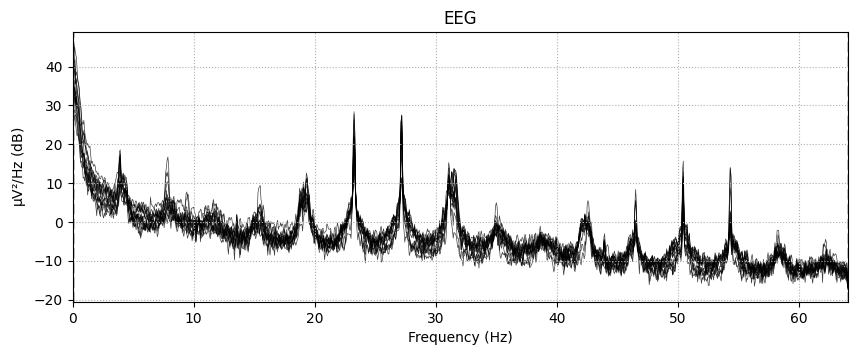

In [26]:
fig3 = raw.plot_psd();

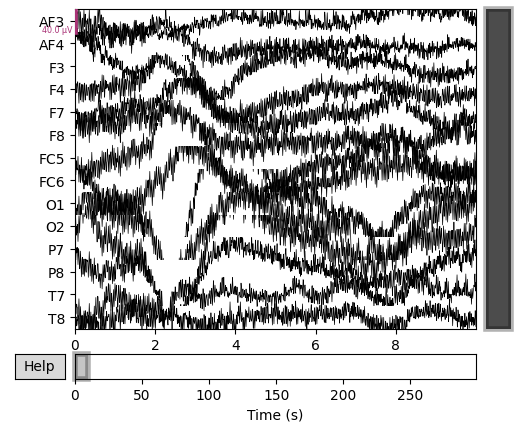

In [27]:
fig= raw.plot()

In [28]:
filtered=raw.filter(0.5,45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 sec)



Effective window size : 16.000 (s)


/var/folders/0c/h9fhkgpn5bsffbb_lm11_n6m0000gn/T/ipykernel_49518/2631827717.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig4=filtered.plot_psd()


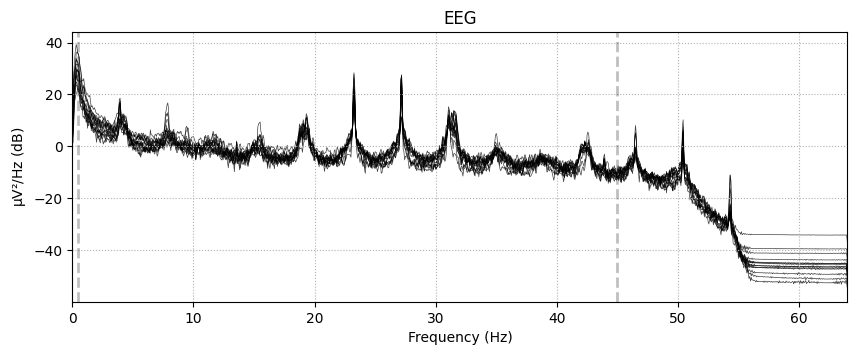

In [29]:
fig4=filtered.plot_psd()

In [30]:
ica=mne.preprocessing.ICA(n_components=8,random_state=0)


In [31]:
filtered.set_montage('standard_1005')


<RawArray | 14 x 38252 (298.8 s), ~4.1 MB, data loaded>

In [32]:
ica.fit(filtered)


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.4s.


<ICA | raw data decomposition, fit (fastica): 38252 samples, 8 components, channels used: "eeg">

/Users/sli-23/.pyenv/versions/3.8.13/lib/python3.8/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/sli-23/.pyenv/versions/3.8.13/lib/python3.8/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/sli-23/.pyenv/versions/3.8.13/lib/python3.8/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/sli-23/.pyenv/versions/3.8.13/lib/python3.8/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.

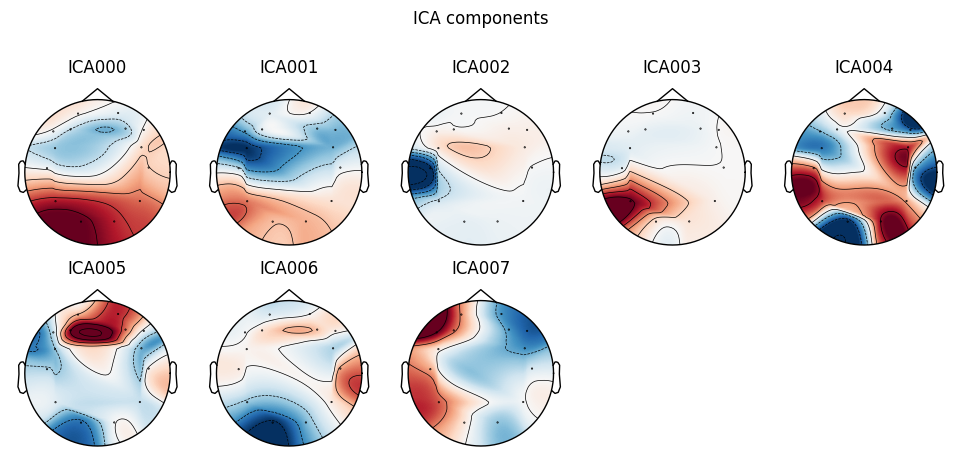

[<Figure size 975x471 with 8 Axes>]

In [33]:
ica.plot_components()


In [34]:
ica.exclude = [1, 2] 


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/sli-23/.pyenv/versions/3.8.13/lib/python3.8/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


Not setting metadata
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/sli-23/.pyenv/versions/3.8.13/lib/python3.8/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


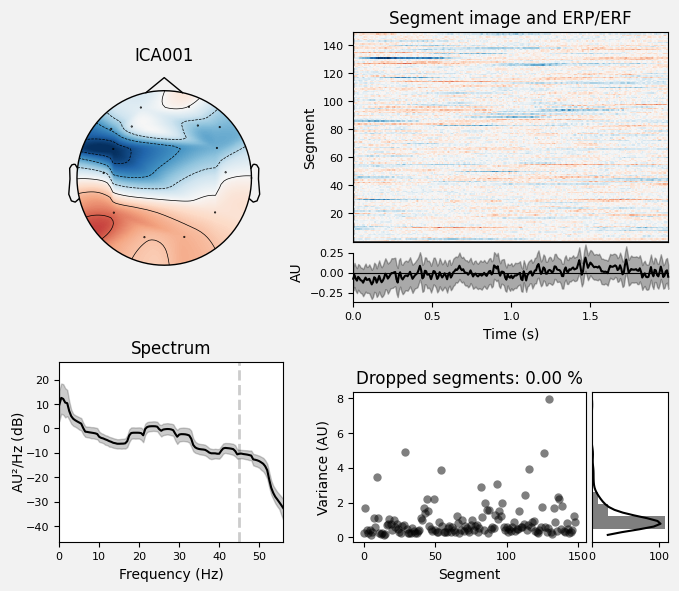

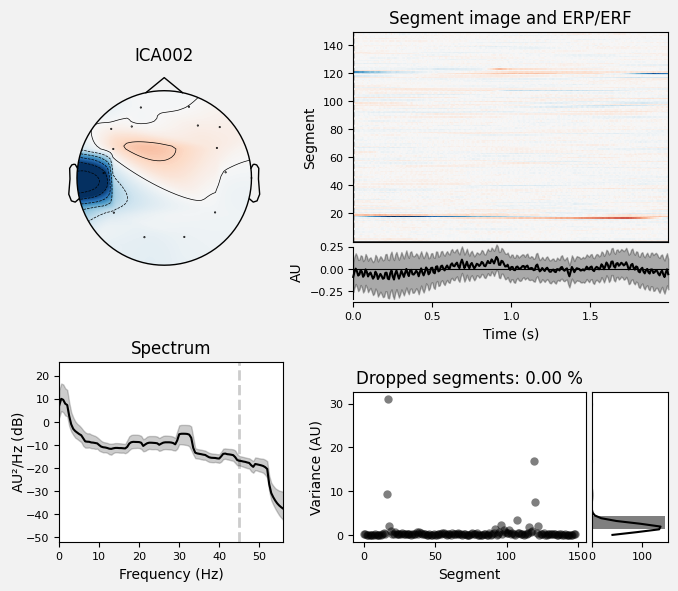

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [35]:
ica.plot_properties(raw, picks=ica.exclude)

In [36]:
raw.set_montage('standard_1005')


<RawArray | 14 x 38252 (298.8 s), ~4.1 MB, data loaded>

In [37]:
raw.info['dig']


[<DigPoint |        LPA : (-84.3, 0.0, 0.0) mm      : head frame>,
 <DigPoint |     Nasion : (-0.0, 104.9, 0.0) mm     : head frame>,
 <DigPoint |        RPA : (84.0, 0.0, 0.0) mm       : head frame>,
 <DigPoint |     EEG #7 : (-33.0, 99.6, 60.5) mm    : head frame>,
 <DigPoint |    EEG #11 : (34.9, 100.6, 61.2) mm    : head frame>,
 <DigPoint |    EEG #16 : (-68.8, 63.7, 31.1) mm    : head frame>,
 <DigPoint |    EEG #18 : (-49.2, 78.0, 82.7) mm    : head frame>,
 <DigPoint |    EEG #22 : (50.7, 79.1, 81.3) mm     : head frame>,
 <DigPoint |    EEG #24 : (71.5, 65.6, 30.5) mm     : head frame>,
 <DigPoint |    EEG #28 : (-75.6, 43.0, 67.9) mm    : head frame>,
 <DigPoint |    EEG #34 : (77.9, 44.3, 67.8) mm     : head frame>,
 <DigPoint |    EEG #38 : (-82.4, 6.7, 37.4) mm     : head frame>,
 <DigPoint |    EEG #46 : (83.3, 7.7, 37.3) mm      : head frame>,
 <DigPoint |    EEG #60 : (-70.9, -48.9, 48.4) mm   : head frame>,
 <DigPoint |    EEG #68 : (71.5, -48.5, 48.3) mm    : head fra

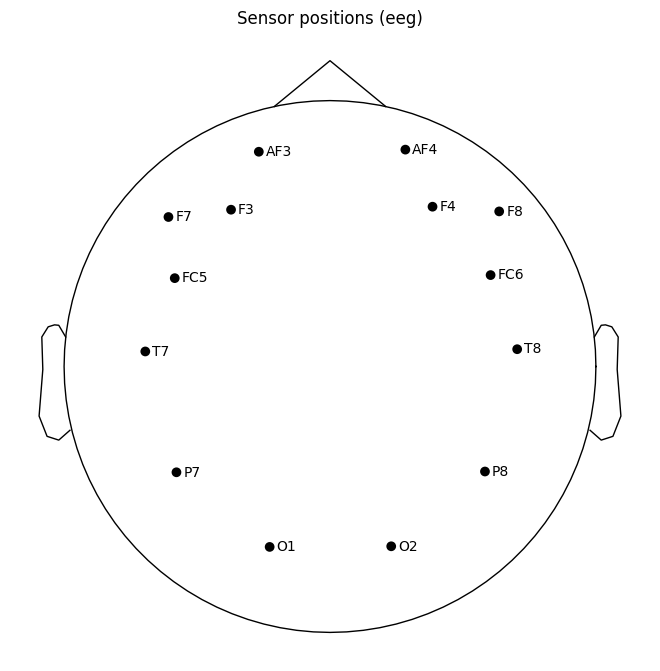

In [38]:
fig2=raw.plot_sensors(show_names=True)


TO DO:
The above part is just for learning and will not be tested in this assignment. ICA requires EEG domain knowledge to perform it accurately. We will now work with preprocessed signal in rest of our analysis. Using the df_labels and df_preprocessed, extract necessary features, visualise them, select the right ones and try to build a classifier. Detailed instructions are provided in assignment pdf.

In [39]:
df_labels = pd.read_csv("GAMEEMO_labels.csv")


In [40]:
df_labels

,subject,game,valence,arousal
0,1,1,1.5,2.0
1,1,2,3.0,2.5
2,1,3,1.5,5.0
3,1,4,3.0,4.5
4,2,1,1.0,1.0
...,...,...,...,...
107,27,4,3.0,2.5
108,28,1,1.0,2.5
109,28,2,4.0,1.5
110,28,3,1.0,2.5


## Feature extraction

In [41]:
sampling_freq = 128 #As mentioned before

freq_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 100)
}

features_list = []

In [42]:
for s in range(28):
    for g in range(4):
        data = df_preprocessed[(df_preprocessed['subject'] == s+1) & (df_preprocessed['game'] == g+1)]
        data = data.drop(columns=['game', 'subject'])
        eeg_data = data.to_numpy()

        # Calculate the power spectral density
        psds = np.zeros((len(channels), len(freq_bands)))
        for i, channel_data in enumerate(eeg_data.T):
            freqs, psd = welch(channel_data, fs=sampling_freq, nperseg=4 * sampling_freq)
            psds[i, :] = [np.mean(psd[(freqs >= band[0]) & (freqs <= band[1])]) for band in freq_bands.values()]

        # Calculate relative band power
        total_power = psds.sum(axis=1)
        relative_band_powers = psds / total_power[:, np.newaxis]
        
        features_list.append(np.hstack((psds.flatten(), relative_band_powers.flatten())))
        label_row = df_labels[(df_labels['subject'] == s+1) & (df_labels['game'] == g+1)]
        valence = label_row['valence'].values[0]
        arousal = label_row['arousal'].values[0]
        valence_category = 1 if valence <= 2 else (2 if valence <= 3.5 else 3)
        arousal_category = 1 if arousal <= 2 else (2 if arousal <= 3.5 else 3)
        features_list[-1] = np.append(features_list[-1], [valence_category, arousal_category])

In [43]:
feature_columns = [f'{band}_{channel}' for band in freq_bands for channel in channels] + \
                  [f'relative_{band}_{channel}' for band in freq_bands for channel in channels] + \
                  ['valence_category', 'arousal_category']
features_df = pd.DataFrame(features_list, columns=feature_columns)

In [44]:
features_df

,delta_AF3,delta_AF4,delta_F3,delta_F4,delta_F7,delta_F8,delta_FC5,delta_FC6,delta_O1,delta_O2,...,relative_gamma_FC5,relative_gamma_FC6,relative_gamma_O1,relative_gamma_O2,relative_gamma_P7,relative_gamma_P8,relative_gamma_T7,relative_gamma_T8,valence_category,arousal_category
0,7.743473,2.295522,1.666522,2.228786,0.343581,11.339873,1.642734,1.584142,2.060378,0.375281,...,0.067538,0.134777,0.010226,0.499268,0.190572,0.106795,0.173744,0.029621,1.0,1.0
1,4.357299,1.455603,0.709613,1.297908,0.561266,6.602461,1.534038,0.726152,1.065591,0.381612,...,0.022127,0.052770,0.011315,0.519192,0.177700,0.080760,0.178252,0.044096,2.0,2.0
2,5.056481,1.351928,0.878086,1.108997,0.365114,4.161964,1.358036,0.900550,0.788406,0.456352,...,0.082817,0.062008,0.027783,0.552350,0.160060,0.137458,0.091330,0.058801,1.0,3.0
3,5.890516,1.412644,0.950980,0.965496,0.722984,3.537226,1.343489,0.918630,0.984298,0.593775,...,0.113531,0.082035,0.066789,0.566644,0.151284,0.125282,0.088343,0.068447,2.0,3.0
4,14.230988,8.580849,4.302001,4.825559,0.617261,10.963483,6.438438,3.813379,4.032995,0.722295,...,0.140430,0.209681,0.020695,0.453640,0.264362,0.125872,0.140774,0.015353,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,65.782738,7.311728,3.594877,1.424434,0.679293,8.005398,2.504055,1.842475,0.671723,0.297464,...,0.018294,0.012129,0.004240,0.475592,0.167470,0.137266,0.148551,0.071121,2.0,2.0
108,153.185413,21.805050,3.525581,1.129622,0.261876,18.379292,4.501322,1.282954,0.595894,0.244834,...,0.108491,0.054698,0.013520,0.630543,0.172058,0.104627,0.075533,0.017239,1.0,2.0
109,109.868452,18.759989,3.399604,1.060546,0.250215,17.424410,4.132085,1.348634,0.625367,0.261605,...,0.099101,0.050227,0.012451,0.607588,0.185318,0.112039,0.076214,0.018842,3.0,1.0
110,142.583385,20.422781,4.371199,1.225217,0.265324,21.591276,4.449478,1.497097,0.671810,0.270328,...,0.118364,0.051917,0.012207,0.675886,0.154220,0.103383,0.055350,0.011161,1.0,2.0


## Feature selection 

In [45]:
X = features_df.drop(columns=['valence_category', 'arousal_category'])
y = features_df['valence_category']

In [46]:
anova_results = {column: f_oneway(X[column], y) for column in X.columns}

In [47]:
sorted_features = sorted(anova_results.items(), key=lambda x: x[1].pvalue)

In [48]:
top_features = sorted_features[:10]

In [49]:
top_features

[('relative_alpha_AF4',
  F_onewayResult(statistic=635.8426182572896, pvalue=4.261511590227591e-67)),
 ('relative_theta_P7',
  F_onewayResult(statistic=634.0265406998743, pvalue=5.393687493314073e-67)),
 ('relative_gamma_F4',
  F_onewayResult(statistic=632.0825418810224, pvalue=6.944749901448127e-67)),
 ('relative_beta_T7',
  F_onewayResult(statistic=631.0381016765682, pvalue=7.95675425178685e-67)),
 ('relative_alpha_FC5',
  F_onewayResult(statistic=630.8893181853907, pvalue=8.112558898978348e-67)),
 ('relative_delta_O2',
  F_onewayResult(statistic=630.4531548505101, pvalue=8.587276738098875e-67)),
 ('relative_beta_FC6',
  F_onewayResult(statistic=629.7074439400753, pvalue=9.464777871743056e-67)),
 ('relative_beta_F3',
  F_onewayResult(statistic=629.6796155404096, pvalue=9.499221446091326e-67)),
 ('relative_gamma_O1',
  F_onewayResult(statistic=629.5532857576246, pvalue=9.657178754814518e-67)),
 ('relative_alpha_P8',
  F_onewayResult(statistic=628.7680937415494, pvalue=1.07001672735525

In [50]:
for feature, result in top_features:
    print(f"Feature: {feature}, F-Value: {result.statistic}, P-Value: {result.pvalue}")

Feature: relative_alpha_AF4, F-Value: 635.8426182572896, P-Value: 4.261511590227591e-67
Feature: relative_theta_P7, F-Value: 634.0265406998743, P-Value: 5.393687493314073e-67
Feature: relative_gamma_F4, F-Value: 632.0825418810224, P-Value: 6.944749901448127e-67
Feature: relative_beta_T7, F-Value: 631.0381016765682, P-Value: 7.95675425178685e-67
Feature: relative_alpha_FC5, F-Value: 630.8893181853907, P-Value: 8.112558898978348e-67
Feature: relative_delta_O2, F-Value: 630.4531548505101, P-Value: 8.587276738098875e-67
Feature: relative_beta_FC6, F-Value: 629.7074439400753, P-Value: 9.464777871743056e-67
Feature: relative_beta_F3, F-Value: 629.6796155404096, P-Value: 9.499221446091326e-67
Feature: relative_gamma_O1, F-Value: 629.5532857576246, P-Value: 9.657178754814518e-67
Feature: relative_alpha_P8, F-Value: 628.7680937415494, P-Value: 1.0700167273552561e-66


## Feature visualization 

In [51]:
features = [feature for feature, result in top_features]
features

['relative_alpha_AF4',
 'relative_theta_P7',
 'relative_gamma_F4',
 'relative_beta_T7',
 'relative_alpha_FC5',
 'relative_delta_O2',
 'relative_beta_FC6',
 'relative_beta_F3',
 'relative_gamma_O1',
 'relative_alpha_P8']

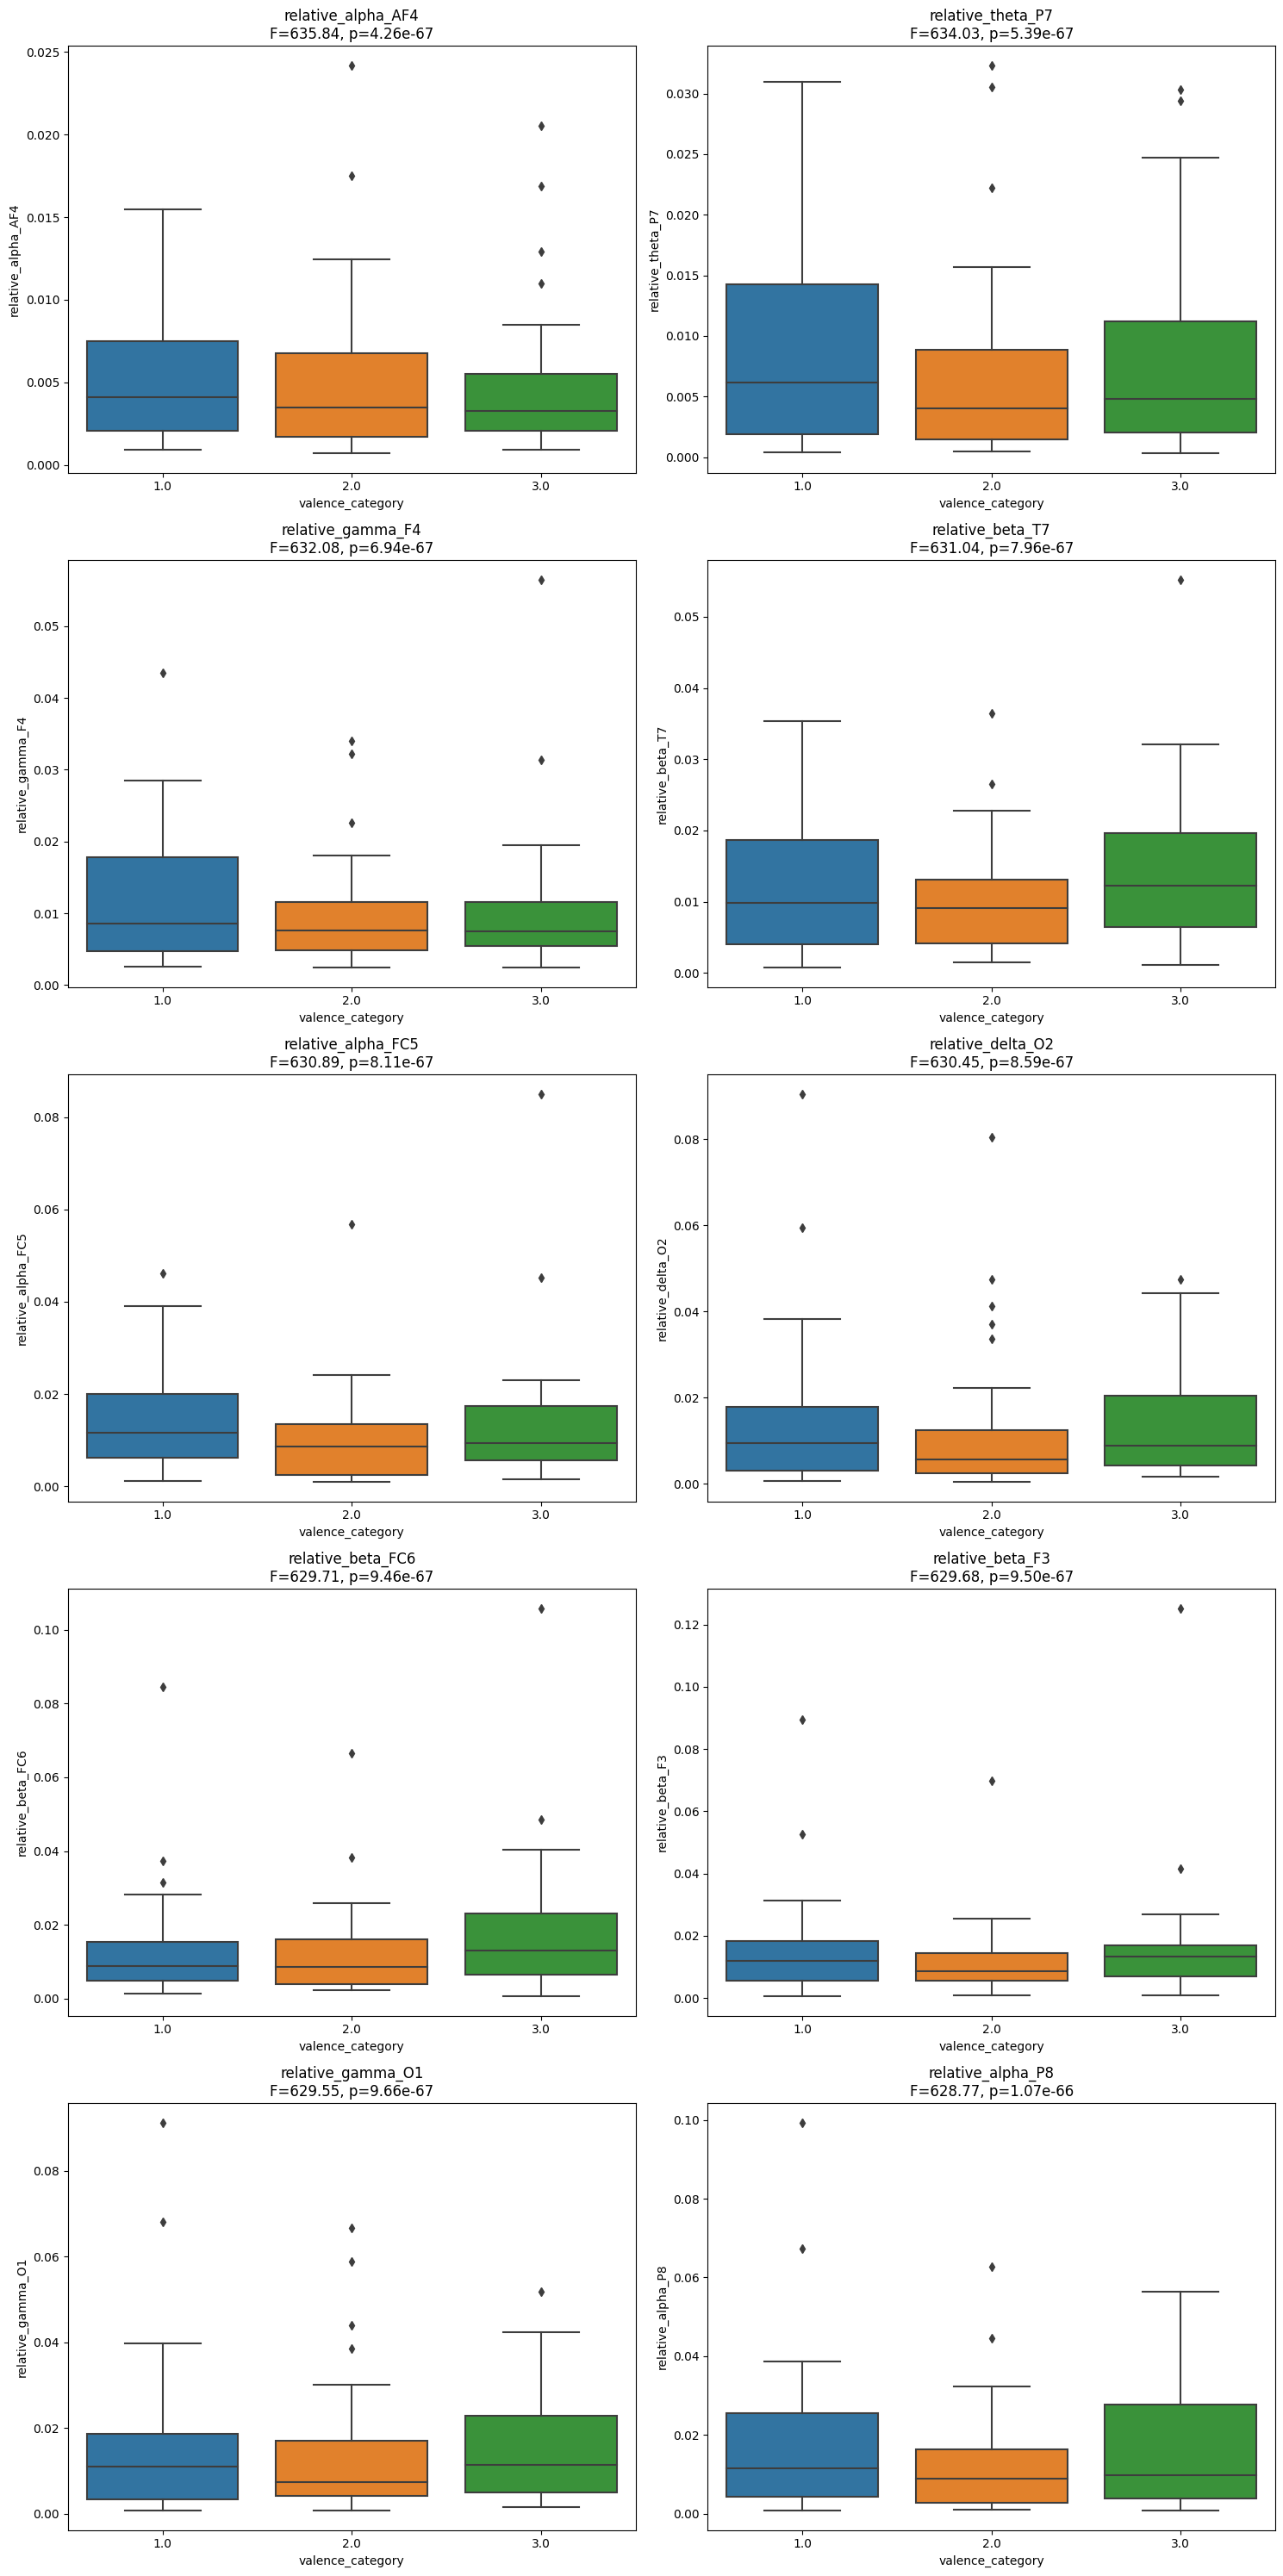

In [52]:
plt.figure(figsize=(15, 30))
for i, feature in enumerate(features):
    plt.subplot(5, 2, i+1)
    sns.boxplot(x='valence_category', y=feature, data=features_df)
    plt.title(f"{feature}\nF={anova_results[feature].statistic:.2f}, p={anova_results[feature].pvalue:.2e}")
plt.tight_layout()
plt.show()

The box plots reveal distinct distributions of relative EEG band powers across different valence categories. Category 1 generally shows higher median values, suggesting it may correlate with a specific emotional state. The statistical significance of the differences is confirmed by the very low p-values, implying distinctions between categories. These findings suggest that integrating EEG band powers as features in a machine learning model could enhance its ability to classify emotional states. However, the presence of outliers highlights the need for robust feature handling to ensure model reliability. 

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
top_features_1 = features_df[features]
principalComponents = pca.fit_transform(top_features_1)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

In [54]:
principalDf

,PC1,PC2
0,-0.003850,-0.003257
1,0.011936,-0.009769
2,0.031115,-0.031399
3,0.055348,-0.048841
4,0.017240,-0.000387
...,...,...
107,0.064296,0.069228
108,-0.003367,-0.014309
109,-0.002575,-0.017173
110,-0.006843,-0.010928


In [55]:
final_Df = pd.concat([principalDf, features_df['valence_category']], axis=1)
final_Df

,PC1,PC2,valence_category
0,-0.003850,-0.003257,1.0
1,0.011936,-0.009769,2.0
2,0.031115,-0.031399,1.0
3,0.055348,-0.048841,2.0
4,0.017240,-0.000387,1.0
...,...,...,...
107,0.064296,0.069228,2.0
108,-0.003367,-0.014309,1.0
109,-0.002575,-0.017173,3.0
110,-0.006843,-0.010928,1.0


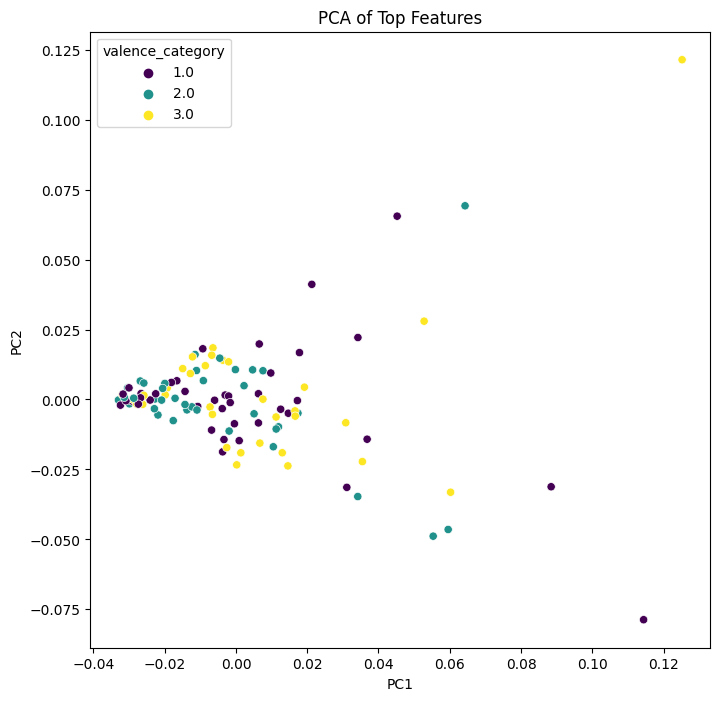

In [56]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', hue='valence_category', data=final_Df, palette='viridis')
plt.title('PCA of Top Features')
plt.show()

The PCA scatter plot of the top features shows the distribution of EEG data points across three valence categories. There appears to be some overlap between the categories, particularly between categories 1 and 2, which are clustered around the center of the plot. Category 3 shows some separation from the other two, although a few points are dispersed among them, suggesting it might be distinguishable based on the PCA-reduced features. However, the absence of clear boundaries between the categories indicates that the top features, while useful, may not fully capture the nuances needed to distinctly classify all valence levels.

## Classification

In [57]:
X = features_df.drop(['valence_category', 'arousal_category'], axis=1)
y = features_df['valence_category']

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=714, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=714, stratify=y_temp)

In [59]:
from sklearn.ensemble import RandomForestClassifier
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

In [60]:
# Train and evaluate the KNN classifier
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KNN Classifier")
print(classification_report(y_test, knn_pred))

KNN Classifier
              precision    recall  f1-score   support

         1.0       0.25      0.38      0.30         8
         2.0       0.25      0.25      0.25         8
         3.0       0.67      0.29      0.40         7

    accuracy                           0.30        23
   macro avg       0.39      0.30      0.32        23
weighted avg       0.38      0.30      0.31        23



In [61]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest Classifier")
print(classification_report(y_test, rf_pred))

Random Forest Classifier
              precision    recall  f1-score   support

         1.0       0.45      0.62      0.53         8
         2.0       0.45      0.62      0.53         8
         3.0       1.00      0.14      0.25         7

    accuracy                           0.48        23
   macro avg       0.64      0.46      0.43        23
weighted avg       0.62      0.48      0.44        23



We can observe that the Random Forest classifier generally outperforms the KNN classifier in terms of precision, recall, and F1 score for the first category. However, its performance drops for the third category, which could indicate a variance in how well each classifier handles different types. The recall is particularly important in applications where missing out on a true positive can be critical. In this case, the Random Forest classifier seems to offer a better balance between precision and recall across the classes, making it a potentially more suitable choice for this task.



In [64]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
classifier = RandomForestClassifier()
unique_labels = np.unique(y)
confusion_mat = np.zeros((len(unique_labels), len(unique_labels)))

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    classifier.fit(X_train, y_train.ravel())
    y_pred = classifier.predict(X_test)
    confusion_mat += confusion_matrix(y_test, y_pred, labels=unique_labels)

In [65]:
precision = np.diag(confusion_mat) / np.sum(confusion_mat, axis=0)
recall = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
f1_scores = 2 * precision * recall / (precision + recall)

# Handle the case where precision + recall equals zero
f1_scores = np.nan_to_num(f1_scores)

# Print out the metrics for each class
for i, label in enumerate(unique_labels):
    print(f"Class {label} - Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1_scores[i]}")

Class 1.0 - Precision: 0.24, Recall: 0.3, F1 Score: 0.2666666666666666
Class 2.0 - Precision: 0.3333333333333333, Recall: 0.34210526315789475, F1 Score: 0.33766233766233766
Class 3.0 - Precision: 0.13043478260869565, Recall: 0.08823529411764706, F1 Score: 0.10526315789473685


Innovative features include asymmetry scores, which compare the activity of hemispheres and are believed to be indicative of emotional valence. Functional connectivity patterns, which assess the network dynamics between different brain regions, have been explored for their relationship with emotional states. Other studies have utilized higher-order spectra, such as bispectrum or trispectrum, to capture the nonlinear aspects of EEG signals related to emotional processing. Time-frequency features like wavelet coefficients, which provide a more detailed view of the signal across both time and frequency, are also gaining attention. Furthermore, entropy-based measures, which quantify the complexity of the EEG signal, and fractal dimensions, which provide insights into the chaotic nature of EEG, are being investigated for their potential to discriminate between different emotions. Integrating these innovative features into the framework of EEG-based emotion recognition could enhance the performance of classification systems, potentially improving the accuracy and robustness of emotion detection.